<a href="https://colab.research.google.com/github/ALAN-K-BIJU/Traffic_Saarthi_Model/blob/main/Traffic_Density_using_Efficientnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'traffic-density-singapore:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2964640%2F5104987%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240215%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240215T173259Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6b41334993edf4533ba07ce5e14daa9d1e2933fe3be6768719873d6125ae6670690c167f54a1be5f118fa2fb831cffe4ff2684d60ab858ceb3f4e4b29e9705fc294168ba21fe81966a072182a7acdb55cbd8b32f260cb947d2dc7af4ab1c296c1d7e13b9a4216ae596df266a6b965693b5e0fe949189498da75a2ab90239ca4a869d7e5fd7b85c546b360f213dd3ea831b5dc66a85fae736c803f0e42e2821f4904a1aa5764b394bd189caa12f9247ff3b1360614652c91f5880090cc1bd9f6d7b6098c6ce5e725eddfec6c87e7b10940c40f3db8839b486053c27d6a0a8f74484f11b9dfd8987497330cf2bae395b4c673222b2c51cf504bbd09f8b5a91a432'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 232976918 bytes downloaded
Downloaded and uncompressed: traffic-density-singapore
Data source import complete.


In [ ]:
import os
import shutil
import random
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.layers import Dense, Flatten,GlobalAveragePooling2D
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Define the directories for the train, validation, and test sets
train_dir = '/kaggle/input/traffic-density-singapore/Final Dataset/training'
val_dir = '/kaggle/input/traffic-density-singapore/Final Dataset/validation'
test_dir = '/kaggle/input/traffic-density-singapore/Final Dataset/testing'
# Define the image dimensions and batch size
img_height = 224
img_width = 224
batch_size = 32
# Define the data generators for the train, validation, and test sets
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    color_mode='rgb')
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_generator = val_datagen.flow_from_directory(val_dir,
                                                target_size=(img_height, img_width),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                color_mode='rgb')
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(val_dir,
                                                target_size=(img_height, img_width),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                color_mode='rgb')

Found 3378 images belonging to 5 classes.
Found 340 images belonging to 5 classes.
Found 340 images belonging to 5 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define your CNN architecture
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
num_epochs = 30
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=num_epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size
)

Epoch 1/30
105/105 [==============================] - 416s 4s/step - loss: 1.9596 - accuracy: 0.3347 - val_loss: 1.3711 - val_accuracy: 0.3938
Epoch 2/30
105/105 [==============================] - 401s 4s/step - loss: 1.3161 - accuracy: 0.4199 - val_loss: 1.2620 - val_accuracy: 0.4281
Epoch 3/30
105/105 [==============================] - 392s 4s/step - loss: 1.2224 - accuracy: 0.4537 - val_loss: 1.1678 - val_accuracy: 0.4750
Epoch 4/30
105/105 [==============================] - 400s 4s/step - loss: 1.1157 - accuracy: 0.5248 - val_loss: 1.4877 - val_accuracy: 0.4344
Epoch 5/30
105/105 [==============================] - 401s 4s/step - loss: 1.0103 - accuracy: 0.5675 - val_loss: 1.1088 - val_accuracy: 0.5281
Epoch 6/30
105/105 [==============================] - 399s 4s/step - loss: 0.9318 - accuracy: 0.5956 - val_loss: 1.0729 - val_accuracy: 0.6000
Epoch 7/30
105/105 [==============================] - 390s 4s/step - loss: 0.8779 - accuracy: 0.6276 - val_loss: 0.9408 - val_accuracy: 0.6094

In [ ]:
class_names = train_generator.class_indices
class_names = {v: k for k, v in class_names.items()}
predictions = model.predict(test_generator)

# Convert the predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)
predicted_labels = [class_names[label] for label in predicted_labels]

# Get the true labels of the test images
true_labels = test_generator.classes
true_labels = [class_names[label] for label in true_labels]

11/11 [==============================] - 11s 886ms/step


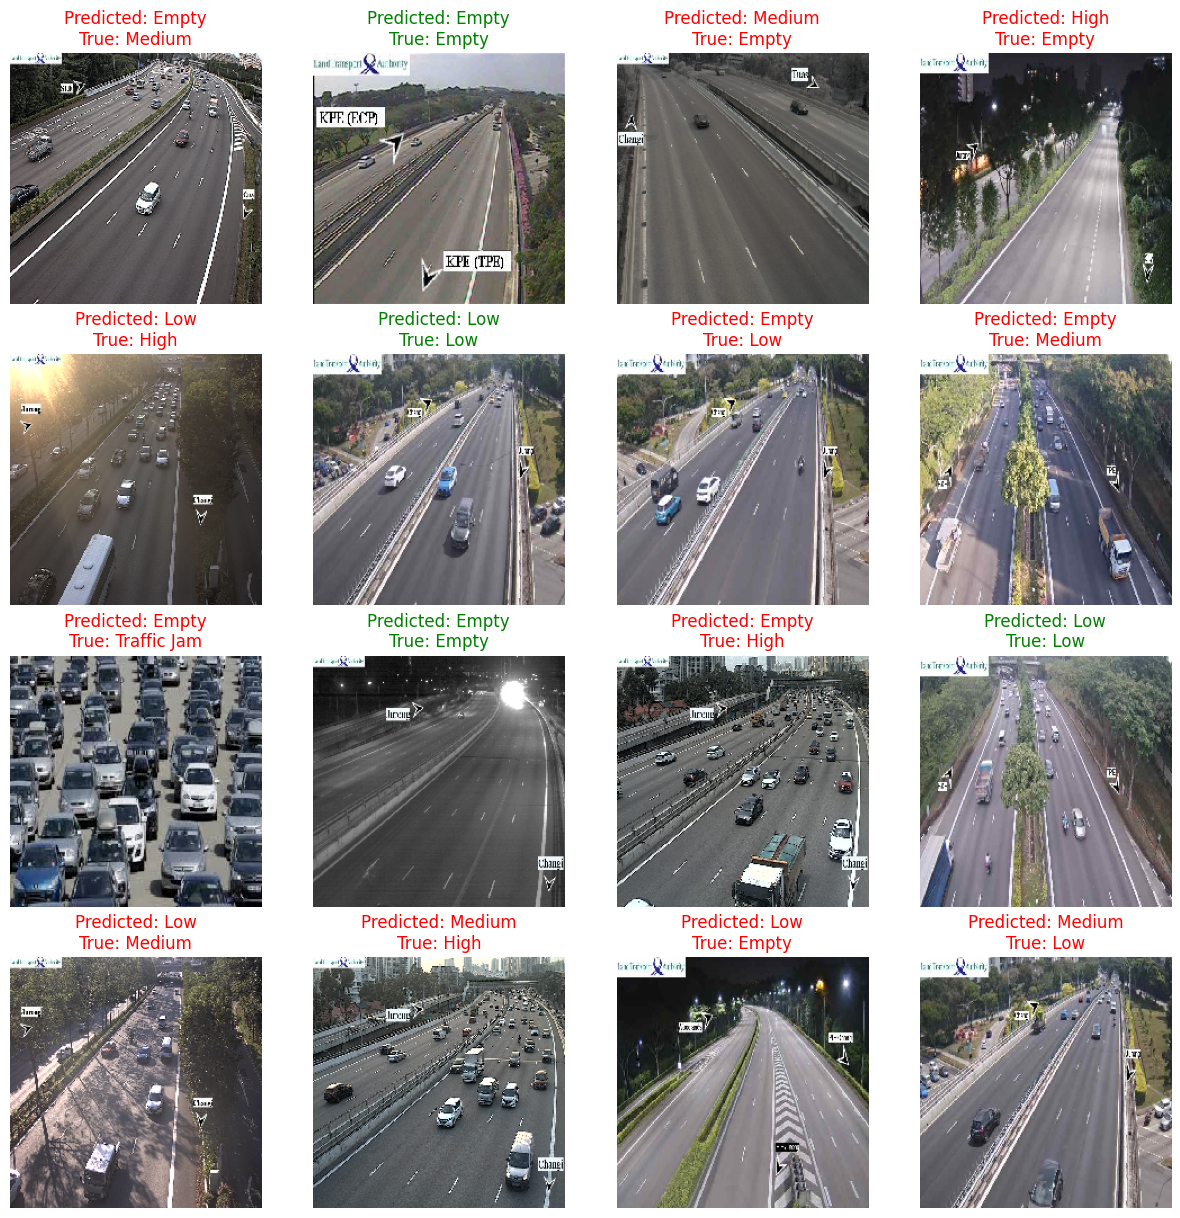

In [ ]:
# Print the predicted and true labels for a subset of test images
n_rows = 4
n_cols = 4
fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 15))

np.random.seed(42)
random_indexes = np.random.choice(len(predicted_labels), size=n_rows*n_cols, replace=False)

for i, index in enumerate(random_indexes):
    img_path = test_generator.filepaths[index]
    img = image.load_img(img_path, target_size=(img_height, img_width))
    axs[i//n_cols, i%n_cols].imshow(img)
    axs[i//n_cols, i%n_cols].axis('off')
    axs[i//n_cols, i%n_cols].set_title("Predicted: {}\nTrue: {}".format(predicted_labels[index], true_labels[index]),
                      color='green' if predicted_labels[index] == true_labels[index] else 'red')
plt.show()